# Introduction 
A complete data-cleaning walkthrough for multiple datasets concerning American SAT scores in New York City (NYC). This is an ideal dataset as NYC is a very diverse and economically fractured city, with many impoverished boroughs that you might expect to underperform on SAT tests. I'll continue to filter by gender and race to identify where the inequalities lie.

**Aims:** demonstrate data cleaning techniques, combining multiple datasets and analysing/visualising data to draw conclusions.

**Dataset link:**  [Main dataset](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
- SAT scores for each high school in New York City


**Additional dataset links**


[School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt)
 - Attendance information for each school in New York City
 
[Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
 - Information on class size for each school
 
[AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)
 - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
 
[Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a)
 - The percentage of students who graduated and other outcome information
 
[Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)
 - Demographic information for each school
 
[School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)
 - Surveys of parents, teachers, and students at each school
 
 
 
 
 **Questions to answer:**
 Is the SAT test unfair and on what basis? race? gender? income? etc...

# Read and exploring datasets

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("../input/nyc-data-set-for-sat-scores-dq/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
# read in the surveys
all_survey = pd.read_csv("../input/nyc-data-set-for-sat-scores-dq/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("../input/nyc-data-set-for-sat-scores-dq/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


# Data cleaning - adding DBN columns
DBN columns appear to be a unique ID for each school - each is unique in the SAT data. For those that are missing a DBN, i'll create one.
- each DBN consists of the characters from 'CSD' column and 'SCHOOL CODE'
- however, in the DBN column, they should be padded 
- i'll define a function and appy it to convert and create the unique DBNs for each row

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(csd):
    csd = str(csd)
    if len(csd) == 1:
         csd = csd.zfill(2)
         return csd
    elif len(csd) == 2:
        return csd
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Data cleaning - convert columns to numeric, finding geographic location
In order to allow numeric calculations for the analysis, will need to convert from strings to numeric datatypes.

**Geographic location**
Also, I'll parse the lat. and lon. coordinates in order to find locate each school's borough location.

At the moment, the location column currently looks like this:

```1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -73.90447525699966)```

I'll define two functions to extract both the lat. and lon. using regex and str.methods

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def latfind(x):
    coords = re.findall(r"\(.+\)", x)
    lat = coords[0].split(',')[0].replace('(', '') #index [0] as latitude comes first
    return lat


def lonfind(x):
    coords = re.findall(r"\(.+\)", x)
    lon = coords[-1].split(',')[-1].replace(')', '') #index [-1] as longitude comes last, replace ) as that appears at end of str this time
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(latfind)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(lonfind)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Data cleaning - condense datasets

**class_size**

Focusing on the class_size dataset, there are many DBN duplicates. Exploring the dataset shows that this is because there are multiple values for the grade, program type, coresubject and core course. Looking at the unique values for grades gives us:

```
array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08', 'MS Core', '09-12', '09'], dtype=object)
```
As we're exploring high school data, according to [Wiki](https://en.wikipedia.org/wiki/Education_in_the_United_States), grades 9 through 12 are high school grades. Therefore, we only want data related to those grades. I'll also filter the dataset to include only 'GEN ED' program type, as it is the most common program.
- filter data by 09 - 12 grades
- filter data by GEN ED program type

There will still be duplicate DBNS after this, due to ```CORE COURSE (MS CORE and 9-12 ONLY)``` and `CORE SUBJECT (MS CORE and 9-12 ONLY columns`, which have unique values pertaining to different class types e.g. English, Maths, etc.
- i'll take the average across every single class using `.agg(np.mean)`, then group by DBN

Now, the only thing left to clean is the `schoolyear` column. I'll simply filter by the most current year within the dataset, which is 2011-2012. 

**graduation dataset**

Both `Demographic` and `Cohort` prevent DBN from being unique. Again, i'll take the most current year for `Cohort` and for `Demographic`, i'll filter by total cohort.

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [6]:
#before combining, will need to convert ap scores to numeric in order to allow analysis
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combining the datasets
**Merge strategy**
- ap_2010 and grauation have missing DBN values
- will use a left join, in order to preserve as many rows from sat_results and minimise null values
- for `"class_size", "demographics", "survey", "hs_directory"`, these contain values required for the analysis, so will use an inner join

The inner merge will result in fewer rows for sat_results as some DBN values that existed in sat_results couldn't be found in the other datasets - but will still provide enough data to establish some correlations with.

After the merge, they'll be some missing data, which we'll fill with the mean of each column. In cases of non-numeric data, we'll further fill with '0'.

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


# Data cleaning - adding additional columns to help with analysis

**School district**
I'll create another column to hold each school district, which is just the first two characters from the `DBN` column. This might help with the analysis as we can see differences across school districts.

In [8]:
def first_two(char):
    return char[0:2]

combined['school_dist'] = combined['DBN'].apply(first_two)

# Data analysis - find correlations
In order to establish the factors that influence SAT scores, i'll create calculate the correlations with `sat_score` and and plot them out. 

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

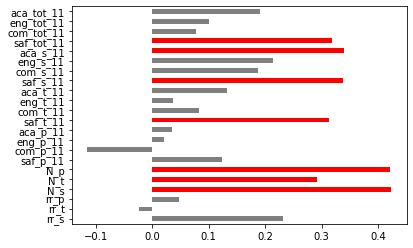

In [11]:
#checking survey fields - correlations between them and sat_score
correlations_survey = combined.corr()['sat_score'] #so correlation is between sat_score only
correlations_survey = correlations_survey[survey_fields]


#highlighting 'interesting' correlations
#highlighting those correlations that are above 0.25 (or below, but can see there are none)
colors = ["red" if i > 0.25 else "grey" for i in correlations_survey]

correlations_survey.plot.barh(color=colors)

plt.show()

### Observations - survey correlations
**highest correlations with sat score**
- saf_tot_10 = Safety and Respect total score
- saf_t_11 = Safety and Respect (teacher)
- saf_s_11 = Safety and Respect (student)
- N_s = Number of student respondents
- N_t = Number of teacher respondents
- N_p = Number of parent respondents


Safety and respect perception are strongly correlated with sat_score, presumably because a safter teaching environment allows students to learn better. 

Respondents response rates (percentage) also correlate strongly with sat_score, presumably because the more students that respond at a school for these surveys might care more about their studies (if we assume response to survey = interest in their studies).


# Data analysis - safety and respect perception
From the above observations, investigating the relationship between safety at school and sat scores seems a logical option.

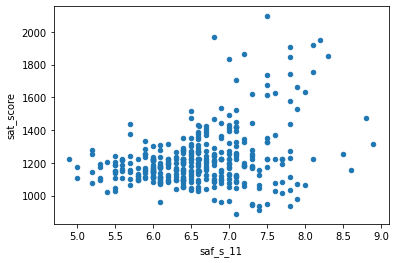

In [12]:
#scatter plot to examine relationship between student safety and sat_score
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

In [13]:
#computing average safety scores for each borough - safety by geographic area
safety = combined.groupby('boro').agg(np.mean)


In [14]:
#student perception
print(safety['saf_s_11'])

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


In [15]:
#teacher perception
print(safety['saf_t_11'])

boro
Bronx            7.026882
Brooklyn         6.985849
Manhattan        7.287778
Queens           7.365625
Staten Island    7.210000
Name: saf_t_11, dtype: float64


### Observations - safety perception
- in general, teachers perceive schools in their geographic area as safer than students
- Brooklyn is rated lower in safety for both teachers and students
- Queens and Manhattan are pereceived as the safety geographic areas, by both students and teachers

The correlation as seen in the scatter plot is not strong - some school have high sat scores and average safety perception. This is a general trend seen in the data. However, there are some that have very high safety perception but average and even sub 1200 sat scores.

# Data analysis - racial inequalities
In order to explore any potential racial unfairness in SAT scores, i'll focus on the following columns:
- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

I'll plot the correlations between these columns and `sat_score` to determine any differences.

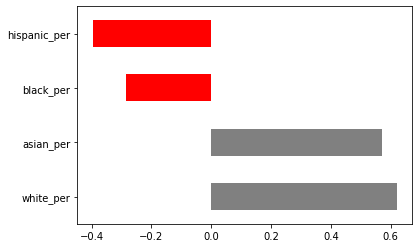

In [16]:
racial_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
sat_corr = combined.corr()['sat_score']
correlations_race = sat_corr[racial_cols]

colors = ["red" if i < -0.25 else "grey" for i in correlations_race]

correlations_race.plot.barh(color=colors)

plt.show()

### Observations - racial differences
From the above data, schools with a high percentage of hispanic or black students have a strong negative correlation with `sat_scores`. The correlation appears the strongest in `hispanic_per`

following on from this, i'll explore:
1. schools with low SAT scores and high values for `hispanic_per`
2. schools with hispanic_per > 95%
3. schools with hispanic_per < 10%, and high SAT scores

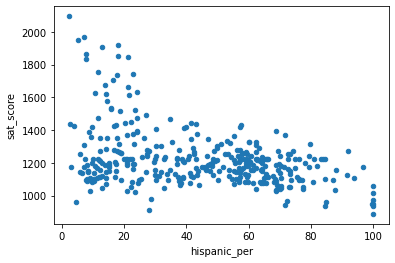

In [17]:
#scatter plot of hispanic_per vs sat_score
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.show()

The above plot shows that the higher the percentage of hispanic students, the lower the SAT scores are. The scatter plot results are typical for a negative correlation.

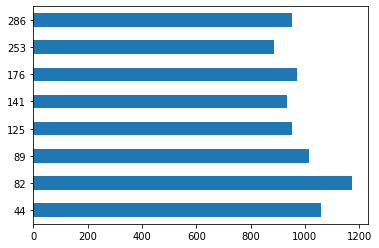

In [18]:
#exploring schools with hispanic populations > 95%
high_hispanic = combined[combined['hispanic_per'] > 95]
high_hispanic['sat_score'].plot.barh()
plt.show()


In [19]:
#there are only 8 rows, can do a google search for each school and see if there's anything we can find in common
print(high_hispanic['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [20]:
#exploring schools with hispanic populations < 10% and high SAT scores
low_hispanic = combined[combined['hispanic_per'] < 10]
low_hispanic = combined[combined['sat_score'] > 1800]
print(low_hispanic['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Observations - 

From a Google/Wiki search...

**High hispanic population**
- most schools located in Manhattan or Bronx, which we have seen before is perceived as being less safe by both students and teachers
- many schools cater to immigrants that may not be already fluent in English

**Low hispanic, high SAT scores**
- most schools located in safer boroughs, with some exceptions
- some schools have academic selection processes for admission 'selective schools'
- many schools have a technical focus on difficult subjects, mathematics or sciences

# Data analysis - gender differences
To investivate gender differences, i'll focus on `male_per` and `female_per`.

In [21]:
gender_cols = ['male_per', 'female_per']
correlations_gender = sat_corr[gender_cols]

In [22]:
print(correlations_gender)

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


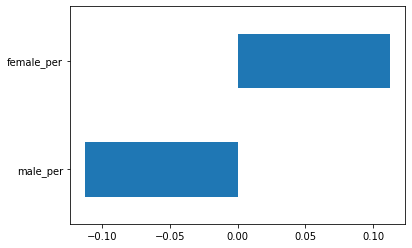

In [23]:
correlations_gender.plot.barh()
plt.show()

Correlations are not very strong - but does show SAT scores positively correlated with females, and negatively correlated with males.

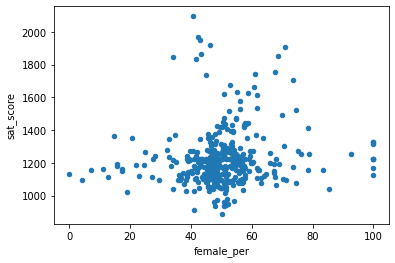

In [24]:
#scatter plot of female_per vs sat_score
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

Does not show a strong correlation - However, when > 60% females, sat scores do increase somewhat until 70~% for a number of schools.

In [25]:
#exploring schools with a female percentage >60% and SAT scores > 1700
high_female = combined[combined['female_per'] > 60]
high_female = combined[combined['sat_score'] > 1700]
print(high_female['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Observations - 
From a wiki search, many high schools with a higher percentage of female students and high SAT scores are:
- selective
- located in a safer borough
- receive additional funding and are more prestigious


# Data analysis - Advanced Placement (AP) results
AP exams are taken at school in order to earn college credit, which support college applications. It makes sense that the number of students enrolled on AP exams are therefore likely to have high SAT scores and are more academically inclined. This should also be reflected in the overall SAT scores for the school.

I'll look into the percentage of students taking at least one AP exam in each school. 

In [26]:
#creating a new column for percentage of AP takers, AP Test Takers / total_enrollment

combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

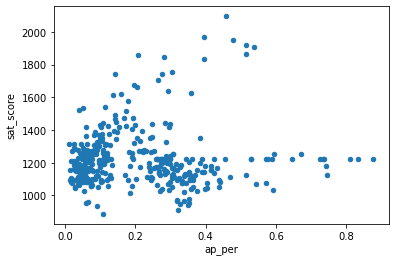

In [27]:
#scatter plot for ap_per vs sat_score
combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()

There isn't a very strong, conclusive correlation. Many results are clustered around the 0 to 20% percentage of AP test takers, showing that most high schools don't have a lot of students enrolled on AP tests. 

As the percentage of AP test takers increase, up until around 60%, SAT scores do increase. 

# Data analysis - class size
To determine if there is a correlation between class size and SAT scores.

I'll focus my analysis on:
- `'AVERAGE CLASS SIZE'`


The column `'SCHOOLWIDE PUPIL-TEACHER RATIO'` values are all 0 and so will not help with the analysis.

In [28]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority06', 'priority07', 'priority08', 'priority09', 'priority10',
       'Location 1', 'lat', 'lon', 'school_dist', 'ap_per'],
      dtype='object', length=161)

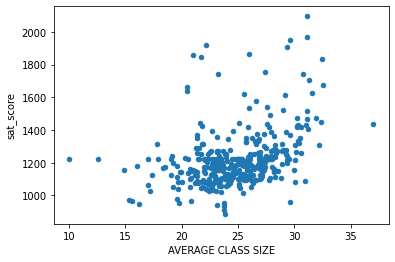

In [29]:
#plotting average class size and SAT scores
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')
plt.show()

Surprisingly, as the class size increases, we can see a slight increase in SAT scores. This could be for a number of factors; the more students enrolled at a school could mean more funding allocated to that school, too. 

# Data analysis - geographic region, (regex)

**Note:** I initially try a regex method to show that the location can be extracted from the `Location 1` column, but there is a separate column enitrely with this data already, called `boro`. I use data from `Location 1` for Brooklyn and Bronx schools, and then filter data using `boro` for the rest of the boroughs.

I'll attempt to separate the data based on its location data, focusing on the areas highlighted previously that are deemed unsafe by student and teachers.
- Brooklyn
- Bronx

In [30]:
#creating a function to help locate areas within Location 1
#I use re.search along with area.group instead of re.findall, as re.findall returns as list instead of str/int
#group() returns string matched by RE, group(0) = full match
def locate_brooklyn(x):
    area = re.search(r"[bB]rooklyn", x)
    return area.group(0) if area else "" #group(0) returns the full string matched by the regex
    
    
combined['brooklyn'] = combined['Location 1'].apply(locate_brooklyn)

In [31]:
combined['brooklyn'].value_counts()

            257
Brooklyn    106
Name: brooklyn, dtype: int64

In [32]:
brooklyn_only = combined[combined['brooklyn'] == 'Brooklyn']

In [33]:
def locate_bronx(x):
    area = re.search(r"[bB]ronx", x)
    return area.group(0) if area else "" 
    
    
combined['bronx'] = combined['Location 1'].apply(locate_bronx)
bronx_only = combined[combined['bronx'] == 'Bronx']

In [34]:
combined['bronx'].value_counts()

         270
Bronx     93
Name: bronx, dtype: int64

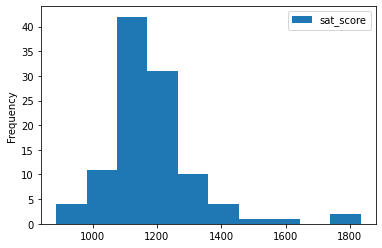

In [35]:
#plotting brooklyn and SAT scores
brooklyn_only.plot.hist(x='brooklyn', y='sat_score')
plt.show()

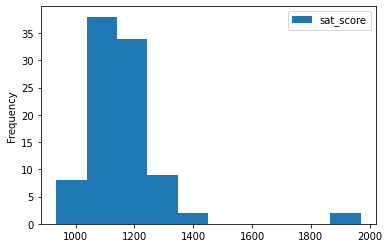

In [36]:
#plotting bronx and SAT scores
bronx_only.plot.hist(x='bronx', y='sat_score')
plt.show()

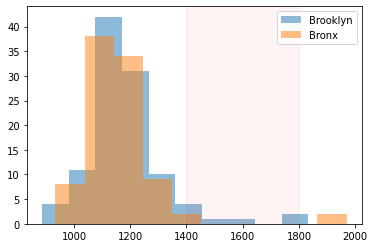

In [37]:
#comparison - plotting a histogram to check distribution of sat scores for schools in both Brooklyn and Bronx
plt.hist(brooklyn_only['sat_score'], alpha=0.5, label='Brooklyn')
plt.hist(bronx_only['sat_score'], alpha=0.5, label='Bronx')
plt.axvspan(xmin=1400, xmax=1800, alpha=0.05, color='Red')
plt.legend()
plt.show()

### Taking a look at 'safer' boroughs

In [38]:
#filtering data using 'boro' column 
manhattan_only = combined[combined['boro'] == 'Manhattan']

In [39]:
queens_only = combined[combined['boro'] == 'Queens']

In [40]:
staten_only = combined[combined['boro'] == 'Staten Island']

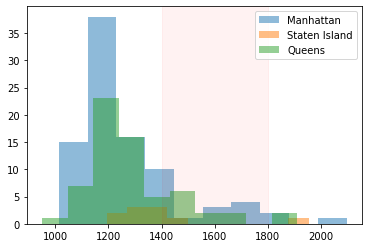

In [41]:
#Manhattan
plt.hist(manhattan_only['sat_score'], alpha=0.5, label='Manhattan')
plt.hist(staten_only['sat_score'], alpha=0.5, label='Staten Island')
plt.hist(queens_only['sat_score'], alpha=0.5, label='Queens')
plt.axvspan(xmin=1400, xmax=1800, alpha=0.05, color='Red')
plt.legend()
plt.show()

In [42]:
queens_only = combined[combined['boro'] == 'Queens']

In [43]:
combined['boro'].unique()

array(['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

### Observations - 
- schools located in both Bronx and Brooklyn show a similar pattern of underperformance in SAT scores
- schools located in safer neighbourhoods have more frequent sat scores > 1400 compared to schools in less safer areas (highlighted)
- majority of schools in all areas achieve average sat scores of 1200~
